# A/B testing with Bayesian Statistics and pymc3
In this notebook I am using pymc3 to perform an A/B test on three different configurations of a university library website, the configurations are displayed below. The variation is the title of one of the links. I will use pymc3, based on bayesian probabliy to see if any of the cnahges can produce statsitically significant results in either a positive or negative mannner.
The data has been taken from http://scholarworks.montana.edu/xmlui/handle/1/3507

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
from PIL import Image
%matplotlib inline

In [3]:
## Loading the data
Data_A=pd.read_csv('../../CrazyEgg/Homepage Version 1 - Interact, 5-29-2013/Element list Homepage Version 1 - Interact, 5-29-2013.csv')
Data_B=pd.read_csv('../../CrazyEgg/Homepage Version 2 - Connect, 5-29-2013/Element list Homepage Version 2 - Connect, 5-29-2013.csv')
Data_C=pd.read_csv('../../CrazyEgg/Homepage Version 3 - Learn, 5-29-2013/Element list Homepage Version 3 - Learn, 5-29-2013.csv')
Data_D=pd.read_csv('../../CrazyEgg/Homepage Version 4 - Help, 5-29-2013/Element list Homepage Version 4 - Help, 5-29-2013.csv')
Data_E=pd.read_csv('../../CrazyEgg/Homepage Version 5 - Services, 5-29-2013/Element list Homepage Version 5 - Services, 5-29-2013.csv')

In [4]:
## Rename a poorly named column
Data_A.rename(columns={'No. clicks':'clicks'},inplace=True)
Data_B.rename(columns={'No. clicks':'clicks'},inplace=True)
Data_C.rename(columns={'No. clicks':'clicks'},inplace=True)
Data_D.rename(columns={'No. clicks':'clicks'},inplace=True)
Data_E.rename(columns={'No. clicks':'clicks'},inplace=True)

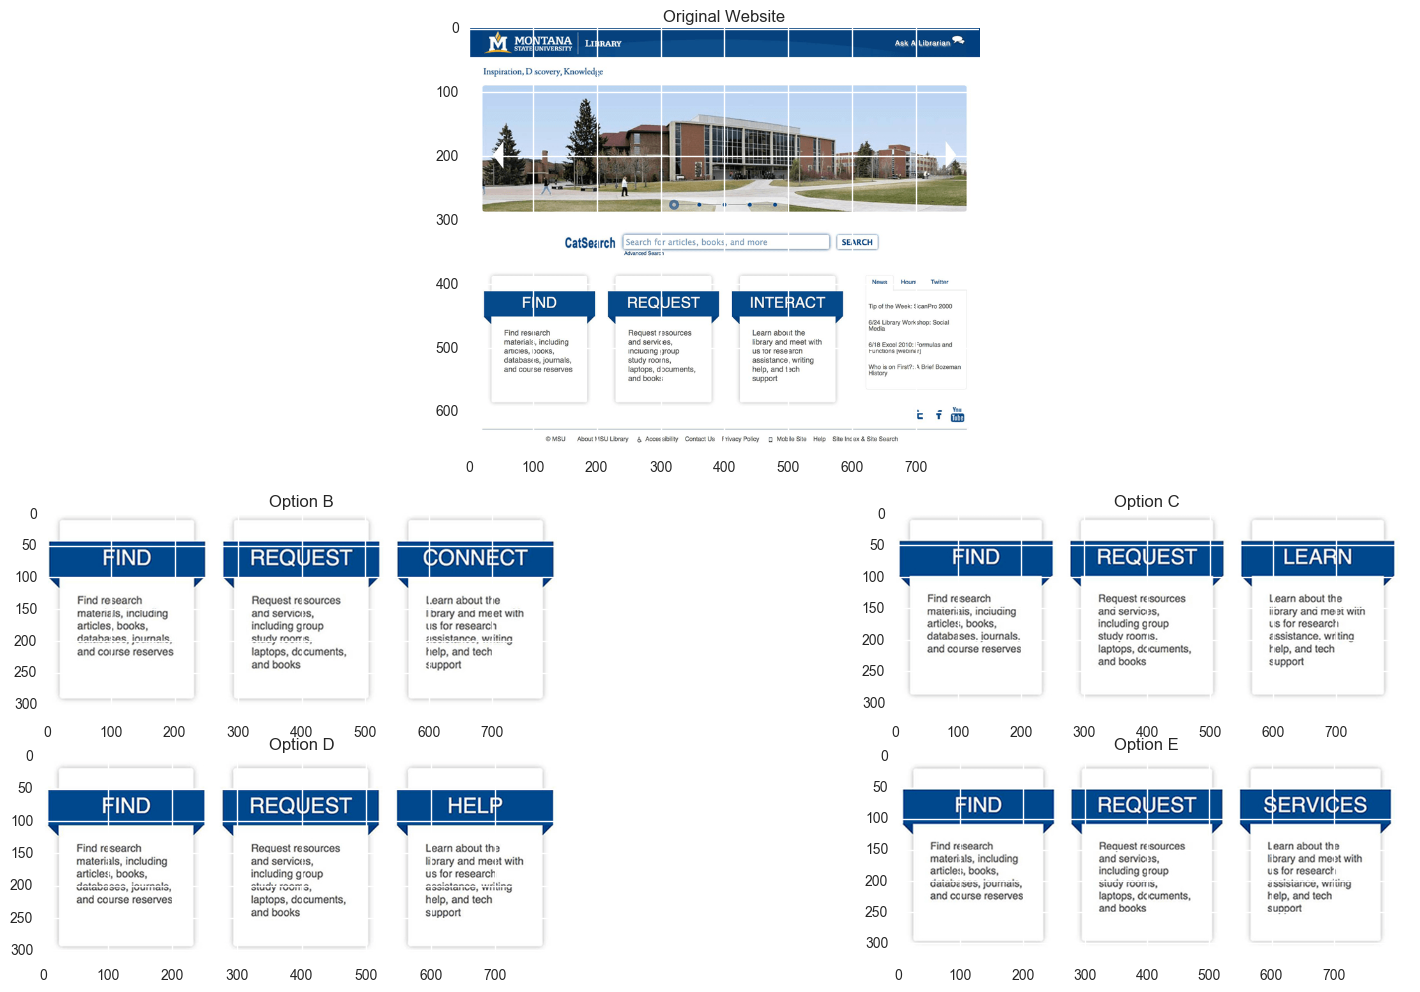

In [75]:
## Plotting the images of the website
fig=plt.figure(figsize=(20,12))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(425)
ax3=fig.add_subplot(426)
ax4=fig.add_subplot(427)
ax5=fig.add_subplot(428)
ax1.imshow(Image.open('A.png'))
ax1.set_title('Original Website')
ax2.imshow(Image.open('B.png'))
ax2.set_title('Option B')
ax3.imshow(Image.open('C.png'))
ax3.set_title('Option C')
ax4.imshow(Image.open('D.png'))
ax4.set_title('Option D')
ax5.imshow(Image.open('E.png'))
ax5.set_title('Option E')

The images above show the format of the website and the changes that are made to each scenario.

In [5]:
Data_B.head(10)

,Element ID,Tag name,Name,clicks,Visible?,Snapshot information
0,74,a,FIND,502,True,Homepage Version 2 - Connect • http://www....
1,66,input,s.q,357,True,created 5-29-2013 • 20 days 7 hours 34 min...
2,72,a,lib.montana.edu/find/,171,True,NaN
3,133,area,Montana State University Libraries - Home,83,False,NaN
4,103,a,Hours,74,True,NaN
5,83,a,REQUEST,57,True,NaN
6,92,a,CONNECT,53,True,NaN
7,67,button,Search,47,True,NaN
8,81,a,lib.montana.edu/request/,31,True,NaN
9,101,a,News,31,True,NaN


In [6]:
## I am only interested in the number of clicks that are used on the website to go to various links, and specifically 
## the proporations of these that are used on the varied link.
Data_A=Data_A[Data_A['Tag name']=='a']
Data_B=Data_B[Data_B['Tag name']=='a']
Data_C=Data_C[Data_C['Tag name']=='a']
Data_D=Data_D[Data_D['Tag name']=='a']
Data_E=Data_E[Data_E['Tag name']=='a']

In [7]:
## I will now sum all of the clicks that have taken place in each of the sets of oberseved data, and the number of 
## clicks directed at the links under investigation.
Total_Clicks_A=Data_A.clicks.sum()
Test_Clicks_A=Data_A[Data_A.Name=='INTERACT'].clicks
Total_Clicks_B=Data_B.clicks.sum()
Test_Clicks_B=Data_B[Data_B.Name=='CONNECT'].clicks
Total_Clicks_C=Data_C.clicks.sum()
Test_Clicks_C=Data_C[Data_C.Name=='LEARN'].clicks
Total_Clicks_D=Data_D.clicks.sum()
Test_Clicks_D=Data_D[Data_D.Name=='HELP'].clicks
Total_Clicks_E=Data_E.clicks.sum()
Test_Clicks_E=Data_E[Data_E.Name=='SERVICES'].clicks

In [47]:
## The proportion of test clicks to total clicks is extremely low, I expect this will lead to results that are not 
## very signifcant due to the relative size.
print Test_Clicks_A/Total_Clicks_A
print Test_Clicks_B/Total_Clicks_B
print Test_Clicks_C/Total_Clicks_C
print Test_Clicks_D/Total_Clicks_D
print Test_Clicks_E/Total_Clicks_E

9    0.025751
Name: clicks, dtype: float64
6    0.051257
Name: clicks, dtype: float64
10    0.019108
Name: clicks, dtype: float64
7    0.034234
Name: clicks, dtype: float64
7    0.053381
Name: clicks, dtype: float64


In [34]:
## Here I am converting the number of clicks into a binary numpy array, with all the positive clicks as 1s and all 
## of the other clicks as 0s.
Bin_Data_A = np.r_[[0] * int(Total_Clicks_A-Test_Clicks_A), [1] * int(Test_Clicks_A)]
Bin_Data_B = np.r_[[0] * int(Total_Clicks_B-Test_Clicks_B), [1] * int(Test_Clicks_B)]
Bin_Data_C = np.r_[[0] * int(Total_Clicks_C-Test_Clicks_C), [1] * int(Test_Clicks_C)]
Bin_Data_D = np.r_[[0] * int(Total_Clicks_D-Test_Clicks_D), [1] * int(Test_Clicks_D)]
Bin_Data_E = np.r_[[0] * int(Total_Clicks_E-Test_Clicks_E), [1] * int(Test_Clicks_E)]

In [39]:
## I will now initialise the model, and create uniform prior distirbutions for each of the scenarios. 
model=pm.Model()
with model:
    p_A = pm.Uniform('p_A', lower=0, upper=1)
    p_B = pm.Uniform('p_B', lower=0, upper=1)
    p_C = pm.Uniform('p_C', lower=0, upper=1)
    p_D = pm.Uniform('p_D', lower=0, upper=1)
    p_E = pm.Uniform('p_E', lower=0, upper=1)

In [40]:
## Using the deterministic function I have created Delta values, that calcualte the difference between the base 
## and test scenarios.
with model:
        delta_B = pm.Deterministic('Delta_B', p_B - p_A)
        delta_C = pm.Deterministic('Delta_C', p_C - p_A)
        delta_D = pm.Deterministic('Delta_D', p_D - p_A)
        delta_E = pm.Deterministic('Delta_E', p_E - p_A)

In [41]:
## Creating distributions of the observed data
with model:
    obs_A = pm.Bernoulli("obs_A", p_A,observed=Bin_Data_A)
    obs_B = pm.Bernoulli("obs_B", p_B,observed=Bin_Data_B)
    obs_C = pm.Bernoulli("obs_C", p_C,observed=Bin_Data_C)
    obs_D = pm.Bernoulli("obs_D", p_D,observed=Bin_Data_D)
    obs_E = pm.Bernoulli("obs_E", p_E,observed=Bin_Data_E)

In [43]:
## Running the markov chain mmonte carlo simulation with metropolis sampling.
with model:
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    
## Burning the first 10000 steps
burned_trace=trace[10000:]

100%|████████████████████████████████████| 25000/25000 [21:22<00:00, 19.50it/s]


In [44]:
burned_trace[0]

{'Delta_B': 0.033486834711919357,
 'Delta_C': -0.0061716469774293591,
 'Delta_D': 0.0056910200748724951,
 'Delta_E': 0.030502931669841193,
 'p_A': 0.029784914246544218,
 'p_A_interval_': -3.4835157528128171,
 'p_B': 0.063271748958463575,
 'p_B_interval_': -2.6949542943881188,
 'p_C': 0.023613267269114859,
 'p_C_interval_': -3.7220500239899121,
 'p_D': 0.035475934321416713,
 'p_D_interval_': -3.30278022332981,
 'p_E': 0.060287845916385412,
 'p_E_interval_': -2.7464430861512428}

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000150C36D8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000015A64400>], dtype=object)

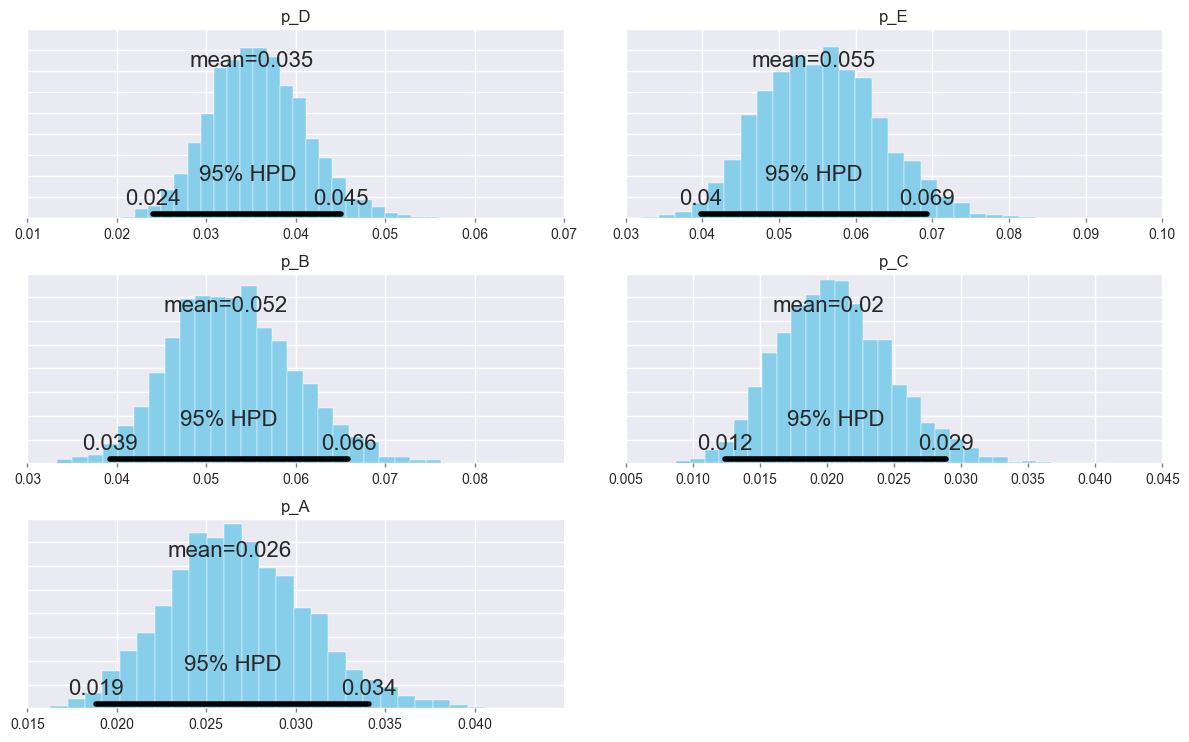

In [46]:
## PLotting the new posteriors for each of the scenarios
pm.plot_posterior(burned_trace,
                  varnames=['p_A', 'p_B','p_C','p_D','p_E'],
                  color='#87ceeb')

## Results - Posteriors
From the distributions above it is clear that option E and B are the two best performing scenarios. There is also alightly noticible different in the squatness of the distributions, those that are fatter (Sample A and E) have a lower overall sample size, hence a wider distribution of probabilities. We can expect when looking at the deltas, that B and E will improve over A and C and D will be worse.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001FD29470>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000002F1426A0>], dtype=object)

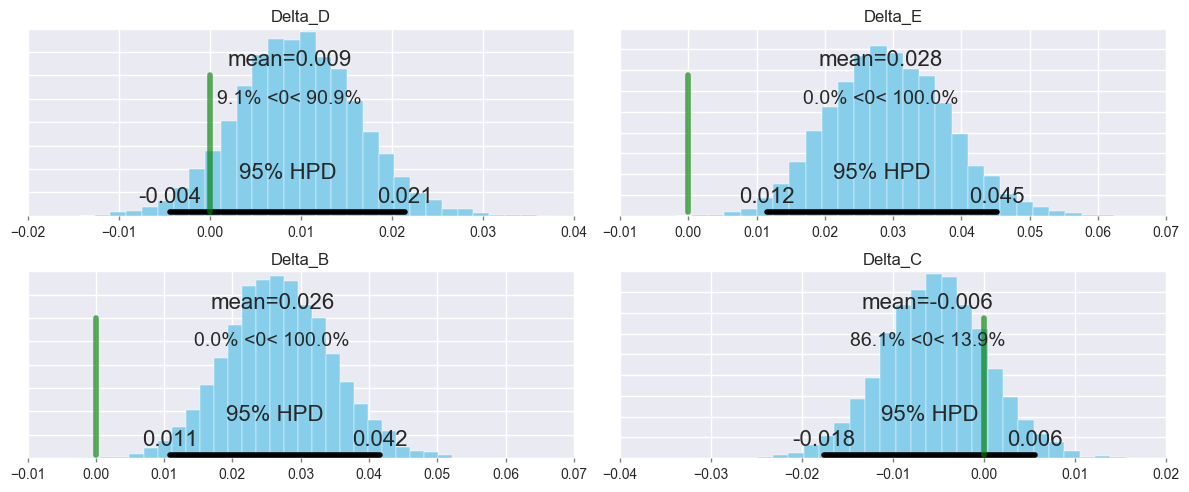

In [76]:
pm.plot_posterior(burned_trace,
                  varnames=['Delta_B', 'Delta_C', 'Delta_D','Delta_E'],
                  ref_val=0,
                  color='#87ceeb')

## Results - Deltas
As expected after looking at the posteriors, scenraios B and E show significant improvment over the control, in fact there is 100% probability that theses scenarios are better. Option D also offeres an improvment however the confidence for this is lower at 90% which would probably be too low for decision making and if this was the only option subsequent trials would be expected. We now have a set of priors that can be used for further analysis once we recieve updated data.

In [48]:
print "Probability site A is BETTER than site B: %.3f" %(burned_trace["Delta_B"] < 0).mean()
print "Probability site A is WORSE than site B: %.3f" %(burned_trace["Delta_B"] > 0).mean()

Probability site A is BETTER than site B: 0.000
Probability site A is WORSE than site B: 1.000


In [49]:
print "Probability site A is BETTER than site C: %.3f" %(burned_trace["Delta_C"] < 0).mean()
print "Probability site A is WORSE than site C: %.3f" %(burned_trace["Delta_C"] > 0).mean()

Probability site A is BETTER than site C: 0.861
Probability site A is WORSE than site C: 0.139


In [50]:
print "Probability site A is BETTER than site D: %.3f" %(burned_trace["Delta_D"] < 0).mean()
print "Probability site A is WORSE than site D: %.3f" %(burned_trace["Delta_D"] > 0).mean()

Probability site A is BETTER than site D: 0.091
Probability site A is WORSE than site D: 0.909


In [51]:
print "Probability site A is BETTER than site E: %.3f" %(burned_trace["Delta_E"] < 0).mean()
print "Probability site A is WORSE than site E: %.3f" %(burned_trace["Delta_E"] > 0).mean()

Probability site A is BETTER than site E: 0.000
Probability site A is WORSE than site E: 1.000
